# Using a DESC Equilibrium Output

## Loading in a DESC Equilibrium
DESC saves its output files as .h5 files, which can be loaded using the load function contained in the `desc.io` module

In [1]:
import desc.io

In DESC, equilibrium solutions are stored as `Equilibrium` objects, which contain the spectral coefficients of the solved equilibrium, as well as last-closed-flux-surface used to solve the equilibrium, input pressure and iota profiles, and other quantities that define the equilibrium. 

Often in DESC, a continuation method is employed to solve for equilibria, where a sequence of related equilibria are computed until the final resolution and input parameters are reached. When calling DESC from the command line, this sequence of `Equilibrium` objects are stored inside of an `EquilibriaFamily` object, which essentially acts as a list of `Equilibrium` objects, with some extra functionality to aid in the continuation method.

We will load in the solution to the `HELIOTRON` example input file we solved in the previous notebook now.

In [2]:
eq_fam = desc.io.load('../00_getting_started_with_DESC/HELIOTRON_continuation_output.h5')
print(type(eq_fam))

DESC version 0.5.0+87.gbaf4601.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 17.99 GB available memory
<class 'desc.equilibrium.EquilibriaFamily'>


As you can see, the object we just loaded in is an `EquilibriaFamily`. We can check to see how many equilibria this family contains (3, each corresponding to a different step in the continuation method outlined in the `HELIOTRON` input file)

In [3]:
len(eq_fam)

3

We can visualize the different equilibria with the `plot_comparison` function, which plots flux surfaces and the contours of constant SFL poloidal angle $\vartheta$ for multiple equilibria

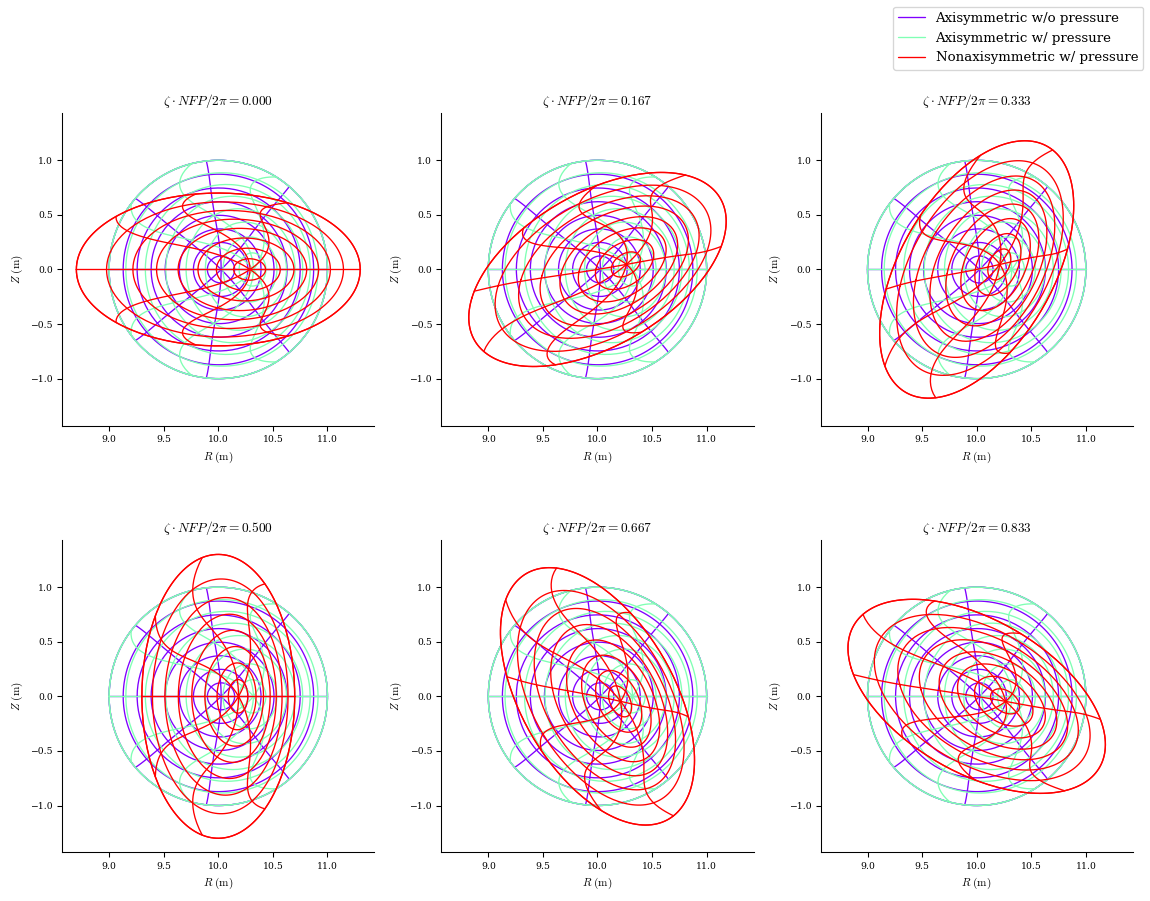

In [4]:
%matplotlib inline
from desc.plotting import plot_comparison
fig, ax = plot_comparison(eqs=[eq_fam[0],eq_fam[1],eq_fam[2]],labels=['Axisymmetric w/o pressure','Axisymmetric w/ pressure','Nonaxisymmetric w/ pressure'])

## Computing Quantities from a DESC Equilibrium

Now let's focus on a single equilibrium. We can choose the final solution by indexing the last element of `eq_fam`

In [5]:
eq = eq_fam[-1]
print(type(eq))

<class 'desc.equilibrium.Equilibrium'>


Notice now we have an `Equilibrium` object, not an `EquilibriaFamily`. Printing an `Equilibrium` will list some information about it

In [6]:
print(eq)

Equilibrium at 0x7f0b6c81ae20 (L=8, M=8, N=3, NFP=19.0, sym=1, spectral_indexing=ansi)


Here we can see that this equilibrium solution has 19 field periods (`NFP=19`) and is represented with a Fourier-Zernike spectral basis with radial resolution of `L=24`, poloidal resolution of `M=12`, and toroidal resolution of `N=3`. It is stellarator symmetric (`sym=1`), and the spectral indexing scheme used for the Zernike Polynomial basis was the `fringe` indexing (for more information on the indexing schemes see the [DESC documentation](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html#Zernike-Polynomials-and-Fourier-Zernike-basis) )

`Equilibrium` objects have a `compute` method which can be used to compute many useful quantities (a full list of which can be found in the [DESC docs](https://desc-docs.readthedocs.io/en/latest/variables.html#list-of-variables)) that are commonly needed from an equilibrium. 

The `compute` method takes as arguments the name (as a string) of the desired quantitity, and optionally the grid you wish the quantity to be computed on (if no grid is supplied it defaults to returning the quantity on a default 3-d grid). It then returns a dictionary containing that quantity, as well as all of the intermediate quantities needed to compute the desired quantity.

As an example, let's plot the pressure and rotational transform profiles of this equilibrium. 

grids in DESC are objects stored in the `desc.grid` module. For plotting grids of linearly spaced points are preferred, so we will use the `LinearGrid` class and make a 1-dimensional grid of points linearly spaced in $\rho$

In [7]:
from desc.grid import LinearGrid
grid_1d = LinearGrid(L=100) # L is the desired number of radial grid points in the LinearGrid

`grid.nodes` shows the points in the grid, each element being $(\rho,\theta,\zeta)$. Notice our grid is an array of points from $\rho=0$ to $\rho=1$ equally spaced, all at $\theta=\zeta=0$

In [8]:
grid_1d.nodes 

array([[0.        , 0.        , 0.        ],
       [0.01010101, 0.        , 0.        ],
       [0.02020202, 0.        , 0.        ],
       [0.03030303, 0.        , 0.        ],
       [0.04040404, 0.        , 0.        ],
       [0.05050505, 0.        , 0.        ],
       [0.06060606, 0.        , 0.        ],
       [0.07070707, 0.        , 0.        ],
       [0.08080808, 0.        , 0.        ],
       [0.09090909, 0.        , 0.        ],
       [0.1010101 , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       [0.12121212, 0.        , 0.        ],
       [0.13131313, 0.        , 0.        ],
       [0.14141414, 0.        , 0.        ],
       [0.15151515, 0.        , 0.        ],
       [0.16161616, 0.        , 0.        ],
       [0.17171717, 0.        , 0.        ],
       [0.18181818, 0.        , 0.        ],
       [0.19191919, 0.        , 0.        ],
       [0.2020202 , 0.        , 0.        ],
       [0.21212121, 0.        , 0.        ],
       [0.

Now we will compute the pressure and iota profiles

In [9]:
pressure_data = eq.compute('p',grid=grid_1d)
iota_data = eq.compute('iota',grid=grid_1d)

In [10]:
pressure_data.keys()

dict_keys(['p', 'p_r'])

In [11]:
iota_data.keys()

dict_keys(['iota', 'iota_r', 'iota_rr'])

Notice that not only was the pressure and rotational transform returned, but also their derivatives in rho. Let's plot the profiles now

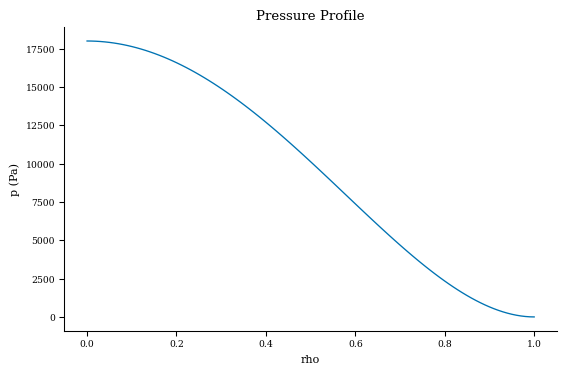

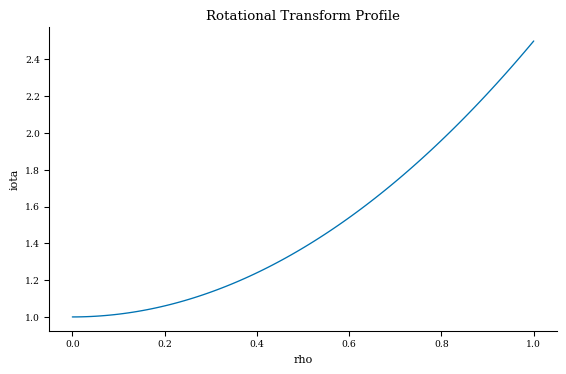

In [12]:
import matplotlib.pyplot as plt
p = pressure_data['p']
iota = iota_data['iota']

plt.figure()
plt.plot(grid_1d.nodes[:,0],p)
plt.title('Pressure Profile')
plt.xlabel('rho')
plt.ylabel('p (Pa)')

plt.figure()
plt.plot(grid_1d.nodes[:,0],iota)
plt.title('Rotational Transform Profile')
plt.xlabel('rho')
plt.ylabel('iota');



Now let's compute the magnetic field strength on the $\rho=0.5$ surface.

When making the grid we will specify that we want poloidal and toroidal grid points using $M$ and $N$, but only at the $\rho=0.5$ surface. Adding the `NFP` argument to the grid will ensure we have toroidal points only for a single field period.

In [13]:
grid_2d_05 = LinearGrid(M=100,N=100,rho=0.5,NFP=eq.NFP)

Notice now that we have gridpoints points at $\rho=0.5$ and $0\leq\theta<2\pi$ and $0\leq\zeta<\frac{2\pi}{NFP}$

In [14]:
grid_2d_05.nodes

array([[0.5       , 0.        , 0.        ],
       [0.5       , 0.06283185, 0.        ],
       [0.5       , 0.12566371, 0.        ],
       ...,
       [0.5       , 6.09468975, 0.32738702],
       [0.5       , 6.1575216 , 0.32738702],
       [0.5       , 6.22035345, 0.32738702]])

In [15]:
mod_B_data = eq.compute('|B|',grid=grid_2d_05)

We can look at the returned dictionary now and see that all of the intermediate quantities necessary to calcuate `|B|` are also returned (the magnetic field covariant and contravariant components, metric tensor elements, etc)

In [16]:
mod_B_data.keys()

dict_keys(['rho', 'theta', 'zeta', 'psi', 'psi_r', 'psi_rr', 'iota', 'iota_r', 'iota_rr', 'lambda', 'lambda_t', 'lambda_z', 'R', 'Z', 'R_r', 'Z_r', 'R_t', 'Z_t', 'R_z', 'Z_z', '0', 'e_rho', 'e_theta', 'e_zeta', 'sqrt(g)', '|e_theta x e_zeta|', '|e_zeta x e_rho|', '|e_rho x e_theta|', 'B0', 'B^rho', 'B^theta', 'B^zeta', 'B', 'B_R', 'B_phi', 'B_Z', 'g_rr', 'g_tt', 'g_zz', 'g_rt', 'g_rz', 'g_tz', '|B|'])

In [17]:
mod_B = mod_B_data['|B|']

To plot this 2d data, it is important to understand that in DESC all quantities and grid points are by default in a single stack. If we look at the shape of `grid_2d.nodes`, we can see that it is 10,000 nodes (1 rho point x 100 theta points x 100 zeta points ), each of length 3 ($\rho,\theta,\zeta$). Similarly,`mod_B` is given at these 10,000 nodes

In [18]:
grid_2d_05.nodes.shape

(10000, 3)

In [19]:
mod_B.shape

(10000,)

To plot this, we must reshape it into a 2D array as follows

Text(0.5, 1.0, '|B| on $\\rho=0.5$ surface')

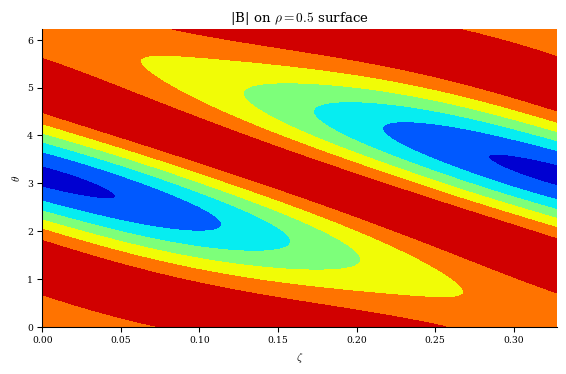

In [20]:
# reshape to form grids for plotting
zeta = (
        grid_2d_05.nodes[:, 2]
        .reshape((grid_2d_05.M, grid_2d_05.L, grid_2d_05.N), order="F")
        .squeeze()
    )
theta = (
    grid_2d_05.nodes[:, 1]
    .reshape((grid_2d_05.M, grid_2d_05.L, grid_2d_05.N), order="F")
    .squeeze()
)
mod_B = mod_B.reshape((grid_2d_05.M, grid_2d_05.L, grid_2d_05.N), order="F") 
# plot contours of |B| on the rho=0.5 surface
plt.contourf(zeta, theta, mod_B[:,0,:],cmap='jet')
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\theta$')
plt.title(r'|B| on $\rho=0.5$ surface')

Hopefully the process of computing quantities from a DESC equilibrium is clearer now. 

For normal plotting needs, DESC has an extensive array of plotting utilities that can be used to quickly plot quantities of interest.

In [21]:
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_boozer_modes, plot_boozer_surface

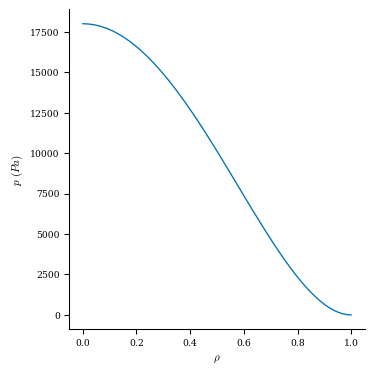

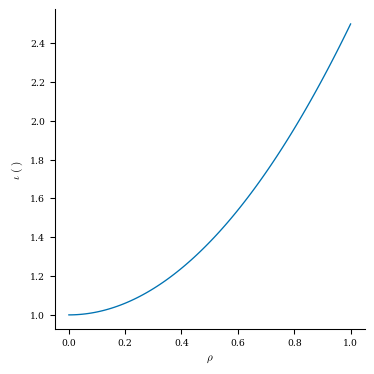

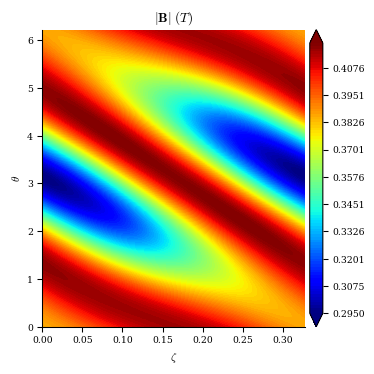

In [22]:
fig, ax = plot_1d(eq,'p')
fig, ax = plot_1d(eq,'iota') 
fig, ax = plot_2d(eq,'|B|',grid=grid_2d_05) # plot mod B on rho=0.5 surface


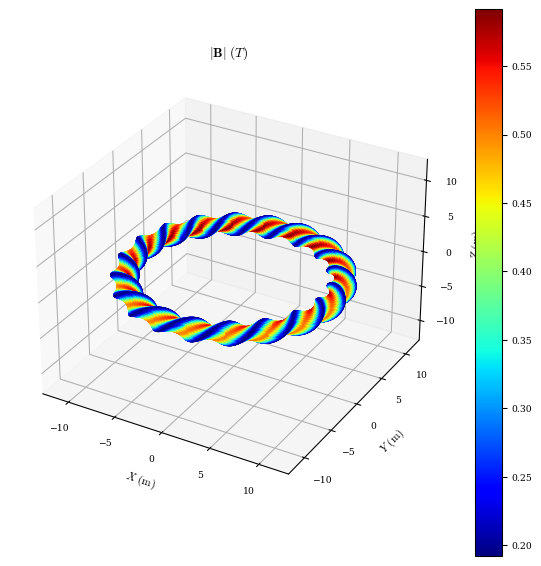

In [23]:
fig, ax = plot_3d(eq,'|B|')

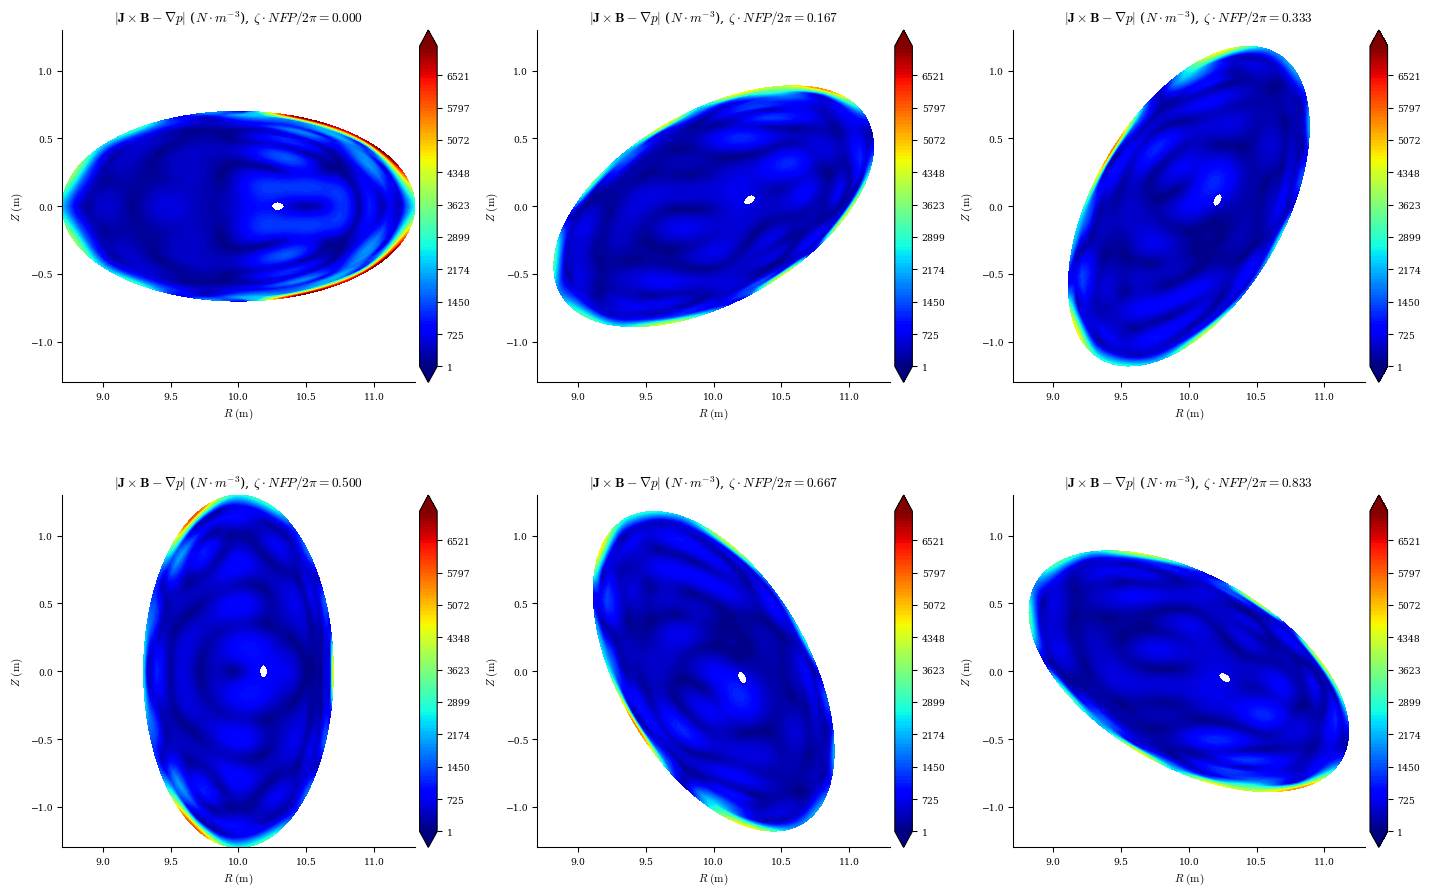

In [24]:
fig, ax = plot_section(eq,'|F|'); # plot force error


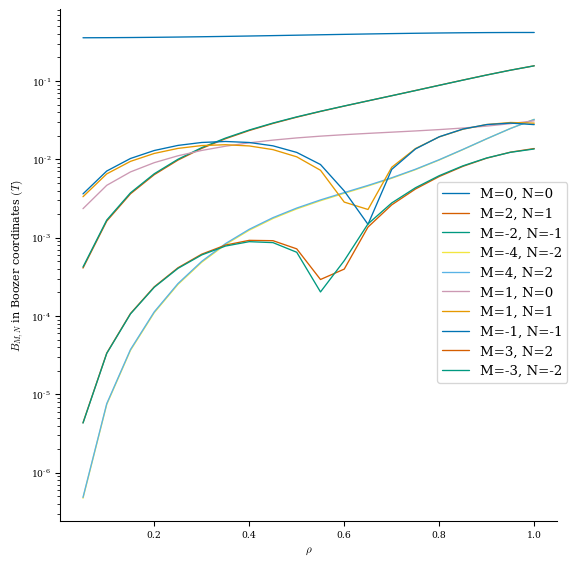

In [25]:
fig, ax = plot_boozer_modes(eq)

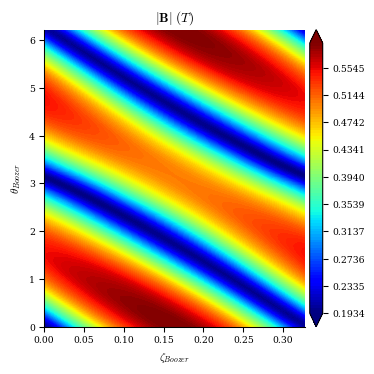

In [27]:
fig, ax = plot_boozer_surface(eq,grid_plot=LinearGrid(rho=0.7, M=100, N=100, NFP=19)) # mod B in Boozer angles on rho=0.7 surface

Each of the plotting routines takes additional arguments that can be used to customize the appearance of the plots, full details can be found in the [documentation](https://desc-docs.readthedocs.io/en/stable/api.html#plotting).

Also note that each plotting function returns a handle to the Matplotlib figure and a numpy array of the axes used. These can then be further modified to customize the appearance of the plots.